In [1]:
import numpy as np
import os
import h5py
import tables
from scipy.io import loadmat

from keras.preprocessing import image

/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image

pascal3d_path = '/home/sprokudin/biternionnet/data/PASCAL3D+_release1.1'

def get_imagenet_data(pascal3d_path, class_name):

    
    def _load_image(img_path):

        img = image.load_img(img_path, target_size=(224, 224))
        x = np.asarray(img)

        return x 
    
    def _parse_annotation(mat_path):
    
        ann = loadmat(mat_path)

        cls_name = ann['record'][0][0][1][0][0][0]
        # bbox = ann['record'][0][0][1][0][0][1]
        viewpoint = ann['record'][0][0][1][0][0][3][0][0]

        azimuth = viewpoint[2]
        elevation = viewpoint[3]
        tilt = viewpoint[8]
        #distance =  viewpoint[4]

        #viewpoint = np.asarray([azimuth, elevation, distance])

        return azimuth, elevation
    
    #ann_path_pascal = os.path.join(pascal3d_path, 'Annotations/%s_pascal/'%class_name)
    ann_path_imagenet = os.path.join(pascal3d_path, 'Annotations/%s_imagenet/'%class_name)
    #imgs_path_pascal =os.path.join(pascal3d_path, 'Images/%s_pascal/'%class_name)
    imgs_path_imagenet = os.path.join(pascal3d_path, 'Images/%s_imagenet/'%class_name)   
    
    #pascal_annotations = os.listdir(ann_path_pascal)
    #pascal_images_fpath = [os.path.join(imgs_path_pascal, ann.split('.')[0]+'.jpg') for ann in pascal_annotations]
    #pascal_annotations_fpath = [os.path.join(ann_path_pascal, ann) for ann in pascal_annotations]

    imagenet_annotations = os.listdir(ann_path_imagenet)
    imagenet_images_fpath = [os.path.join(imgs_path_imagenet, ann.split('.')[0]+'.JPEG') for ann in imagenet_annotations]
    imagenet_annotations_fpath = [os.path.join(ann_path_imagenet, ann) for ann in imagenet_annotations]

    labels = np.zeros([len(imagenet_annotations), 3])
    images = np.zeros([len(imagenet_annotations), 224, 224, 3], dtype='uint8')

    for i in range(0, len(imagenet_annotations)):
        azimuth, elevation = _parse_annotation(imagenet_annotations_fpath[i])
        labels[i, 0] = azimuth
        labels[i, 1] = elevation
        images[i] = _load_image(imagenet_images_fpath[i])
        if i%50 == 0 :
            print("parsed %d samples.."% i)
    
    azimuth_deg =  labels[:, 0]
    elevation_deg =  labels[:, 1]
    tilt_deg =  labels[:, 2]

    data = {'images': images,
            'azimuth_deg': azimuth_deg.reshape([-1, 1]),
            'azimuth_bit': deg2bit(azimuth_deg),
            'elevation_deg': elevation_deg.reshape([-1, 1]),
            'elevation_bit': deg2bit(elevation_deg),
            'tilt_deg': tilt_deg.reshape([-1, 1]),
            'tilt_bit': deg2bit(tilt_deg)}
    
    return data

In [3]:
from utils.angles import bit2deg, deg2bit, rad2bit
imagenet_train_data = get_imagenet_data(pascal3d_path, 'aeroplane')

parsed 0 samples..
parsed 50 samples..
parsed 100 samples..
parsed 150 samples..
parsed 200 samples..
parsed 250 samples..
parsed 300 samples..
parsed 350 samples..
parsed 400 samples..
parsed 450 samples..
parsed 500 samples..
parsed 550 samples..
parsed 600 samples..
parsed 650 samples..
parsed 700 samples..
parsed 750 samples..
parsed 800 samples..
parsed 850 samples..
parsed 900 samples..
parsed 950 samples..
parsed 1000 samples..
parsed 1050 samples..
parsed 1100 samples..
parsed 1150 samples..
parsed 1200 samples..
parsed 1250 samples..
parsed 1300 samples..
parsed 1350 samples..
parsed 1400 samples..
parsed 1450 samples..
parsed 1500 samples..
parsed 1550 samples..
parsed 1600 samples..
parsed 1650 samples..
parsed 1700 samples..
parsed 1750 samples..
parsed 1800 samples..
parsed 1850 samples..
parsed 1900 samples..
parsed 1950 samples..


In [4]:
from utils.angles import bit2deg, deg2bit

def stitch_data_dicts(real_dict, syn_dict):

    stitched = {}
    for key in real_dict.keys():    
        stitched[key] = np.vstack([real_dict[key], syn_dict[key]])

    return stitched

def train_val_split(data, val_split=0.1):

    n_samples = len(data['images'])

    shuffled_samples = np.random.choice(n_samples, n_samples, replace=False)
    n_train = int((1-val_split)*n_samples)
    train_samples = shuffled_samples[0:n_train]
    val_samples = shuffled_samples[n_train:]

    train_data = {} 
    val_data = {}

    for key in data.keys():
        train_data[key] = data[key][train_samples]
        val_data[key] = data[key][val_samples]

    return train_data, val_data

def get_data(dbpath, class_name, 
             use_real=True,
             use_synthetic=True, 
             test_bboxes='gt'):
    
    pascal_db = h5py.File(dbpath, 'r')

    def _get_data_part(h5path):
        
        images = np.asarray(pascal_db[os.path.join(h5path, 'images')])
        labels = np.asarray(pascal_db[os.path.join(h5path, 'labels')])
        azimuth_deg =  labels[:, 1]
        elevation_deg =  labels[:, 2]
        tilt_deg =  labels[:, 3]

        data = {'images': images,
                'azimuth_deg': azimuth_deg.reshape([-1, 1]),
                'azimuth_bit': deg2bit(azimuth_deg),
                'elevation_deg': elevation_deg.reshape([-1, 1]),
                'elevation_bit': deg2bit(elevation_deg),
                'tilt_deg': tilt_deg.reshape([-1, 1]),
                'tilt_bit': deg2bit(tilt_deg)}
        
        return data
    
    if use_synthetic and use_real:
        train_data_real = _get_data_part(os.path.join('train_real', class_name))
        train_data_syn = _get_data_part(os.path.join('train_synthetic', class_name))
        train_data = stitch_data_dicts(train_data_real, train_data_syn)
    elif use_synthetic:
        train_data = _get_data_part(os.path.join('train_synthetic', class_name))
    elif use_real:
        train_data = _get_data_part(os.path.join('train_real', class_name))
    
    if test_bboxes == 'gt':
        test_data_real = _get_data_part(os.path.join('test_real_gt_boxes', class_name))
    else:
        test_data_real = _get_data_part(os.path.join('test_real_frcnn_boxes', class_name))
    
    # test_data_syn = _get_data_part(os.path.join('test_syn_boxes', class_name))
    
    data = {'train': train_data,
            'test': test_data_real}
    
    pascal_db.close()
    
    return train_data, test_data_real

In [5]:
dbpath = '../data/pascal3d_real_synthetic100k.h5'

pascal_train_data, test_data = get_data(dbpath, 'aeroplane', use_synthetic=False)

train_val_data = stitch_data_dicts(pascal_train_data, imagenet_train_data)

train_real_data, val_data = train_val_split(train_val_data, val_split=0.2)

#train_syn_data, _ = get_data(dbpath, 'aeroplane', use_real=False)
#train_data = stitch_data_dicts(train_real_data, train_syn_data)
train_data = train_real_data

n_train_images, image_height, image_width, n_channels = train_data['images'].shape

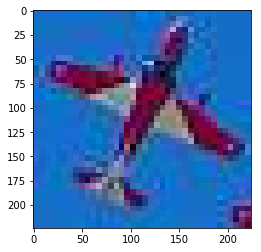

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(np.asarray(train_data['images'][81], dtype='uint8'))

In [17]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.resnet50 import ResNet50

from models import vgg

from utils.losses import maad_from_deg
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras


def biternion_disco(image_height, image_width, n_channels,
                   debug=False,
                  name='biternion_cnn', loss_type='cosine',
                  backbone_cnn_type='inception_resnet',
                  add_noise=True,
                  n_samples=5,
                  z_size=4,
                  hlayer_size=512,
                  noise_std=1.0,
                  learning_rate=1.0e-3, fixed_kappa=1.0):
    
    if debug:
        X_input = Input(shape=[image_height, image_width, n_channels], name='input_image')

        x = Flatten(input_shape=[image_height, image_width, n_channels])(X_input)
    else:
        backbone_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                                          input_shape=[image_height, image_width, n_channels])
        x = backbone_model.output
        x = GlobalAveragePooling2D()(x)

    x = Dense(z_size*16, activation='relu')(x)
    x = Dense(z_size*4, activation='relu')(x)
    x = Dense(z_size, activation='relu')(x)
    
    def _sample_z(x):
        return K.random_normal(shape=K.shape(x[:, 0:z_size]), mean=0., stddev=noise_std)

    #z = Lambda(_sample_z)(x)
    decoder_seq = Sequential(name='decoder')
    if add_noise:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[2*z_size]))
    else:
        decoder_seq.add(Dense(hlayer_size, activation='relu', input_shape=[z_size]))
    
    decoder_seq.add(Dense(hlayer_size, activation='relu'))

    decoder_mean = Sequential()
    decoder_mean.add(decoder_seq)
    decoder_mean.add((Dense(2, activation='linear')))
    decoder_mean.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='theta_mean'))

    decoder_kappa = Sequential()
    decoder_kappa.add(decoder_seq)
    decoder_kappa.add((Dense(1,  activation='linear')))
    decoder_kappa.add(Lambda(lambda x: K.abs(x), name='theta_kappa'))

    z_lst = []
    x_z_lst = []
    x_z_decoded_lst = []
    
    if add_noise:
        for k in range(0, n_samples):
            z_lst.append(Lambda(_sample_z)(x))
            x_z_lst.append(concatenate([x, z_lst[k]]))
            #x_z_decoded_lst.append(decoder_kappa(x_z_lst[k]))
            x_z_decoded_lst.append(concatenate([decoder_mean(x_z_lst[k]), decoder_kappa(x_z_lst[k])]))

        x_z_decoded_all = concatenate(x_z_decoded_lst)
    else:
        x_z_decoded_all = concatenate([decoder_mean(x), decoder_kappa(x)])
    
    # model = Model(backbone_model.input, x_z_decoded_all )
    if debug:
        model = Model(X_input, x_z_decoded_all )
    else:
        model = Model(backbone_model.input, x_z_decoded_all)
    
    def _unpack_preds(y_pred):
        
        theta_mean = y_pred[:, 0:2]
        theta_kappa =  y_pred[:, 2:3]

        return theta_mean, theta_kappa
    
    def _unpack_target(y_target):
        
        theta_target = y_target[:, 0:2]
        
        return theta_target
    
    def _loss(y_target, y_pred):
        
        theta_mean, theta_kappa = _unpack_preds(y_pred)
        theta_target = _unpack_target(y_target)
        
        loss = -von_mises_log_likelihood_tf(theta_target, theta_mean, theta_kappa)
             
        return loss
    
    def _mc_loss(y_target, y_pred):
        
        sample_likelihoods = []
        
        for sid in range(0, n_samples):
            
            sample_likelihoods.append(K.exp(von_mises_log_likelihood_tf(y_target, 
                                                                   y_pred[:, sid*3:sid*3+2], 
                                                                   y_pred[:, sid*3+2:sid*3+3])))
            
        
        mc_likelihood = -K.log(1.0e-20 + K.mean(concatenate(sample_likelihoods), axis=1))
                      
        return mc_likelihood
    
    opt = Adam(lr=learning_rate)
    
    if add_noise:
        model.compile(optimizer=opt, loss=_mc_loss)
    else:
        model.compile(optimizer=opt, loss=_loss)
        
    return model

In [11]:
K.clear_session()
n_samples= 10
bidisco = biternion_disco(image_height, image_width, n_channels,
                          debug=True,
                          n_samples=n_samples, 
                          hlayer_size=512,
                          add_noise=True,
                          z_size=4, noise_std=1.0e0,
                          learning_rate=1.0e-4)

In [10]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(n_epochs=15, batch_size=32, learning_rate=1.0e-4, iteration=0, n_samples=10):
    
    ckpt_path = '../logs/azimuth_disco_multi_iter%d.ckpt'%iteration
    angle = 'azimuth'
    angle_key = angle+'_bit'
    
    K.clear_session()
    bidisco = biternion_disco(image_height, image_width, n_channels,
                              debug=False,
                              n_samples=n_samples, 
                              hlayer_size=512,
                              add_noise=True,
                              z_size=4, noise_std=1.0e0,
                              learning_rate=learning_rate)

    early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

    model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

    time_callback = TimeHistory()

    bidisco.fit(train_data['images'], train_data[angle_key],
              validation_data=[val_data['images'], val_data[angle_key]],
              epochs=n_epochs,
              batch_size=batch_size,
              callbacks=[early_stop_cb, model_ckpt, time_callback])

    bidisco.load_weights(ckpt_path)
    print("FINAL LOG-LIKELIHOOD: %f" % bidisco.evaluate(test_data['images'], test_data['azimuth_bit']))

In [29]:
for i in range(0, 10):
    train_model(n_epochs=200, batch_size=32, iteration=i)

Train on 2247 samples, validate on 562 samples
Epoch 1/200
2247/2247 [==============================] - 6362s 3s/step - loss: 1.6267 - val_loss: 2.2556

Epoch 00001: val_loss improved from inf to 2.25561, saving model to ../logs/azimuth_disco_multi_iter0.ckpt
Epoch 2/200
2247/2247 [==============================] - 6894s 3s/step - loss: 1.0413 - val_loss: 1.1659

Epoch 00002: val_loss improved from 2.25561 to 1.16588, saving model to ../logs/azimuth_disco_multi_iter0.ckpt
Epoch 3/200
2247/2247 [==============================] - 7107s 3s/step - loss: 0.6680 - val_loss: 0.9378

Epoch 00003: val_loss improved from 1.16588 to 0.93781, saving model to ../logs/azimuth_disco_multi_iter0.ckpt
Epoch 4/200
2247/2247 [==============================] - 7166s 3s/step - loss: 0.3841 - val_loss: 0.8012

Epoch 00004: val_loss improved from 0.93781 to 0.80116, saving model to ../logs/azimuth_disco_multi_iter0.ckpt
Epoch 5/200
2247/2247 [==============================] - 7179s 3s/step - loss: 0.1535 - v

KeyboardInterrupt: 

In [31]:
n_samples=10
bidisco = biternion_disco(image_height, image_width, n_channels,
                          debug=False,
                          n_samples=n_samples, 
                          hlayer_size=512,
                          add_noise=True,
                          z_size=4, noise_std=1.0e0,
                          learning_rate=1.0e-4)

bidisco.load_weights('../logs/azimuth_disco_multi_iter0.ckpt')
bidisco.evaluate(test_data['images'], test_data['azimuth_bit'])

275/275 [==============================] - 278s 1s/step


0.8854563229734247

START!!!
275/275 [==============================] - 276s 1s/step
MAAD (1 sample) : 26.835359
MAAD (MAE) : 26.131864
log-likelihood: -0.877953


/home/sprokudin/biternionnet/py_env/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


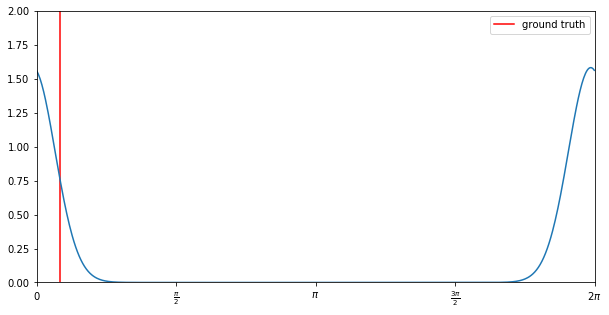

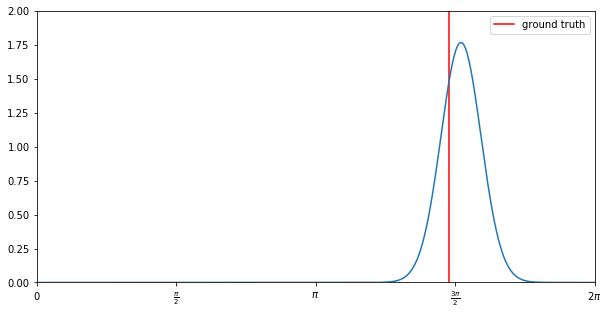

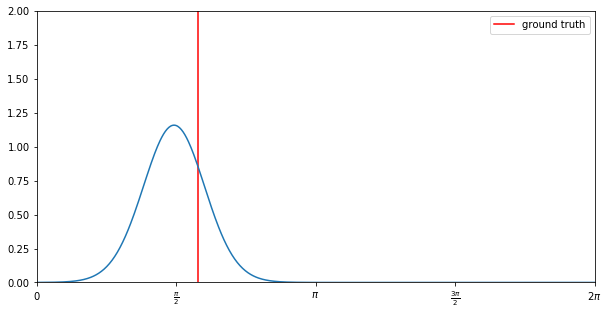

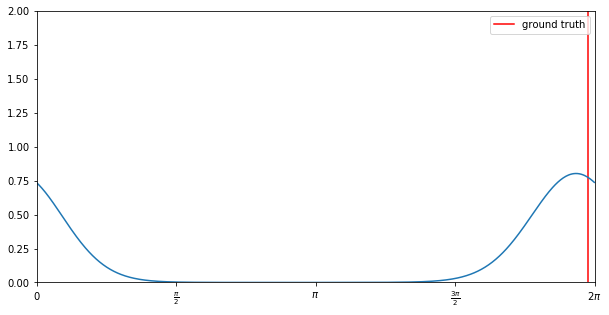

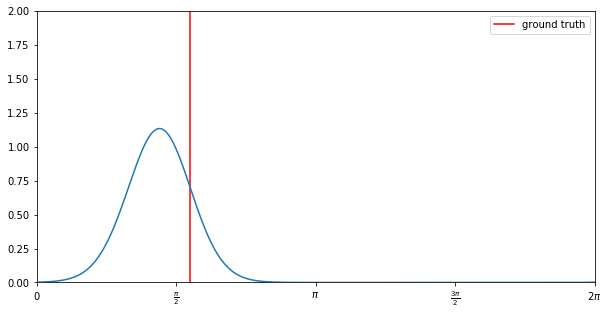

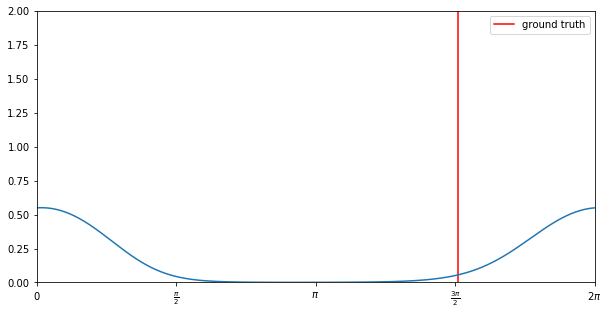

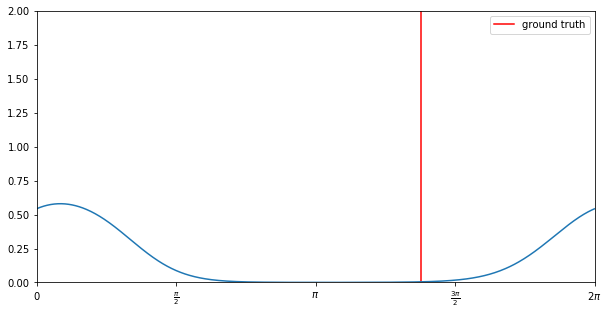

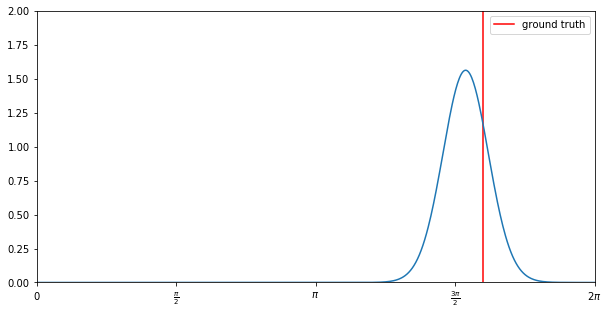

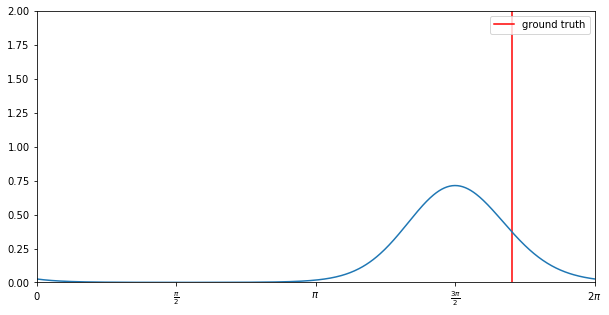

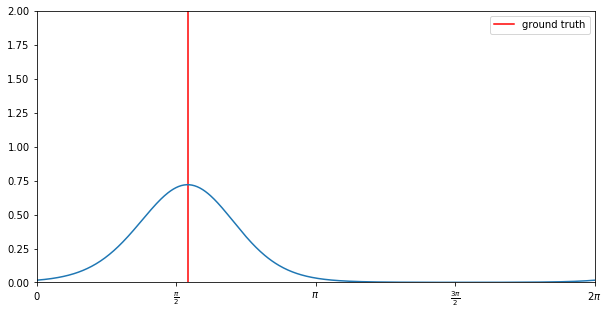

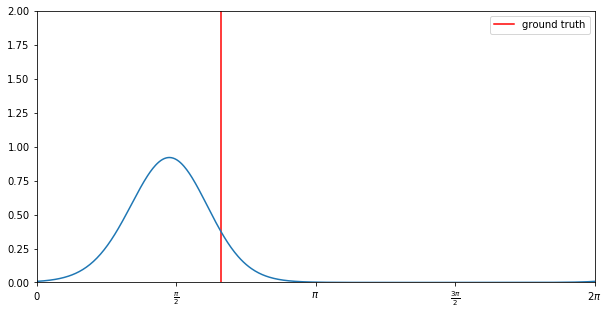

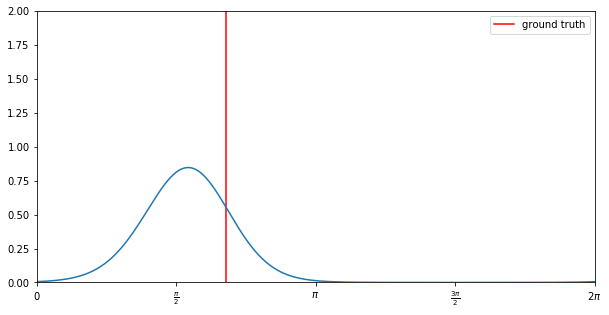

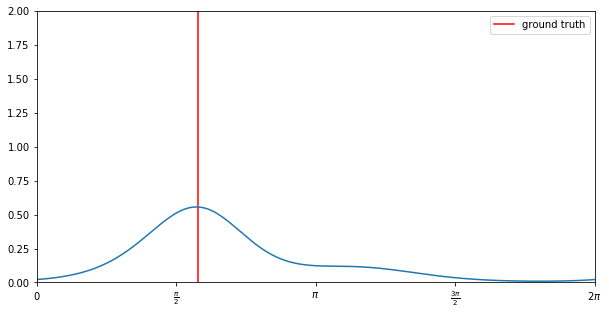

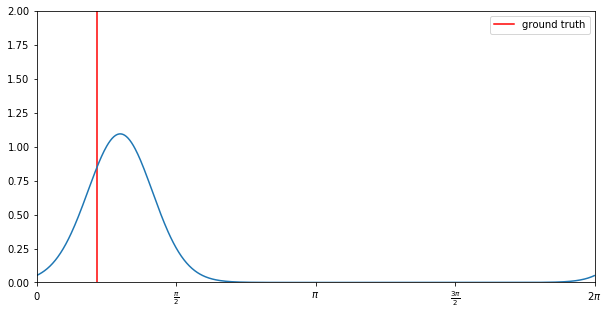

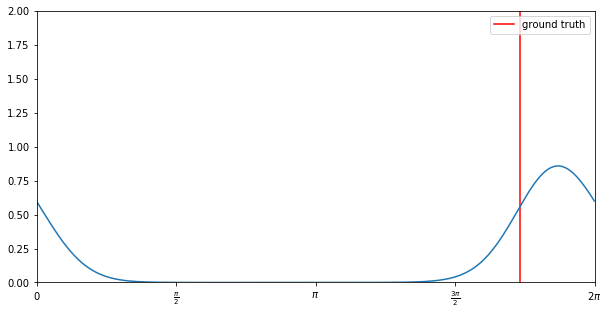

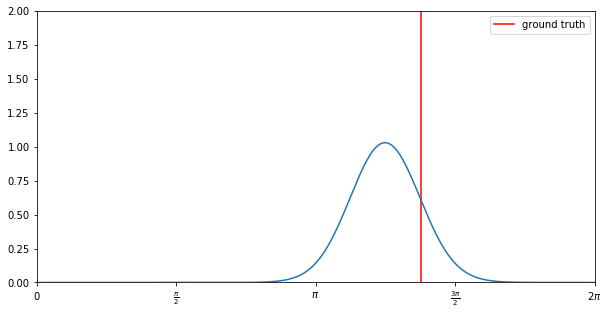

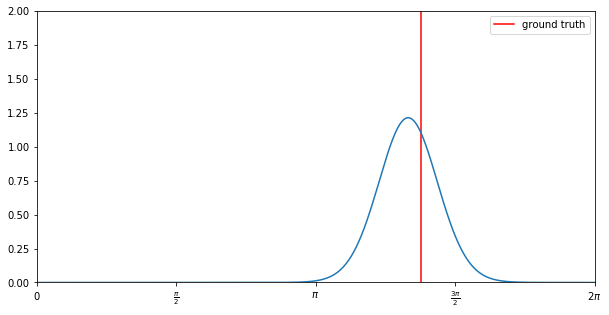

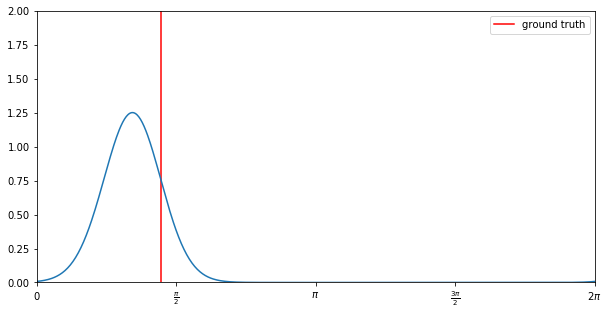

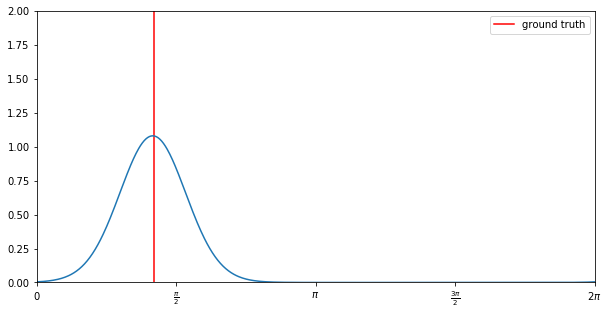

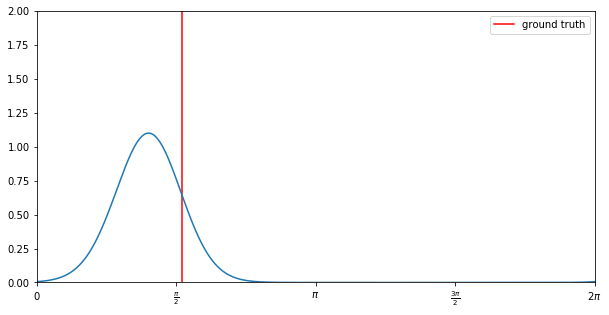

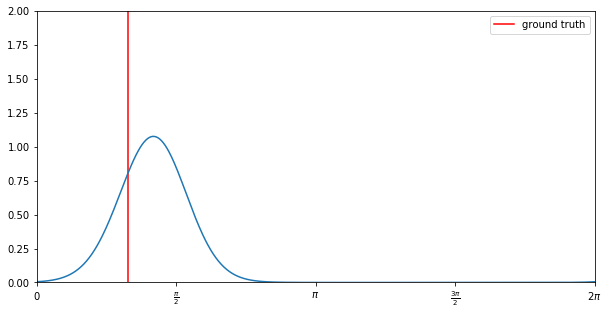

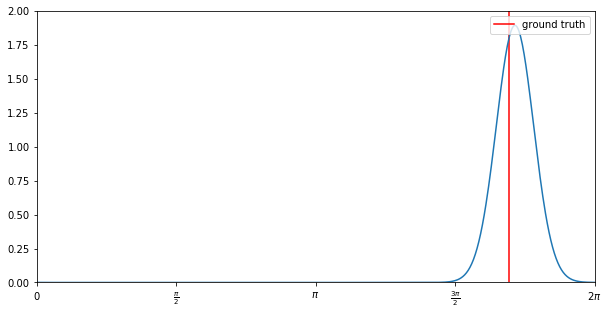

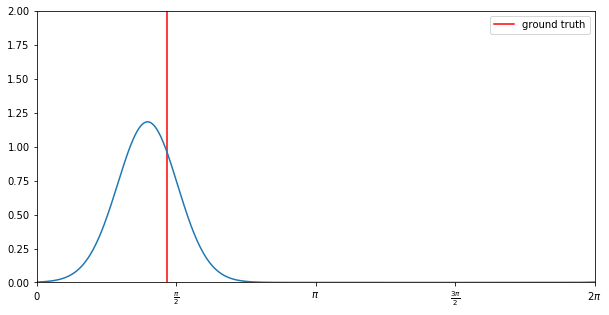

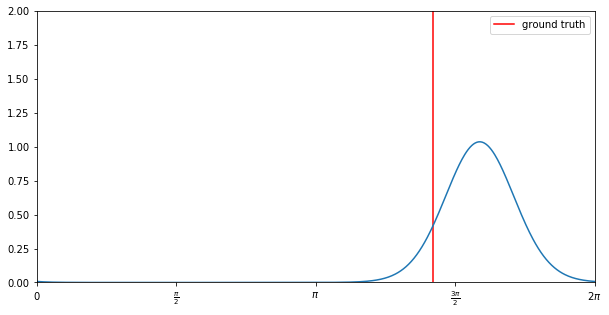

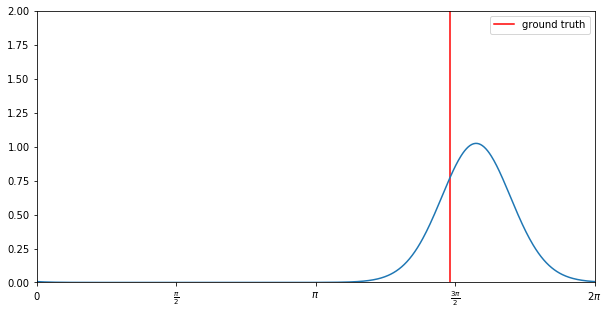

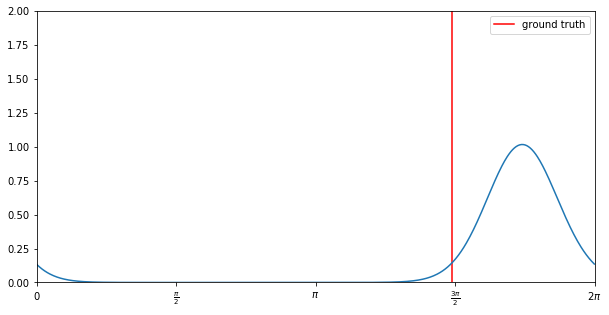

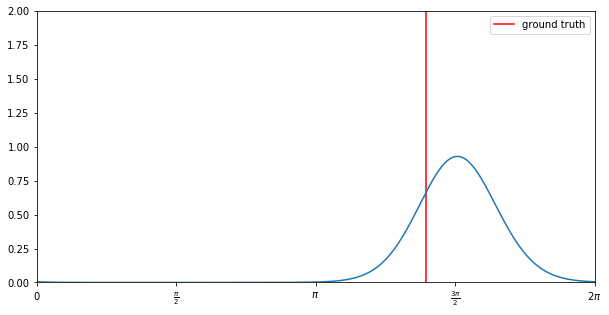

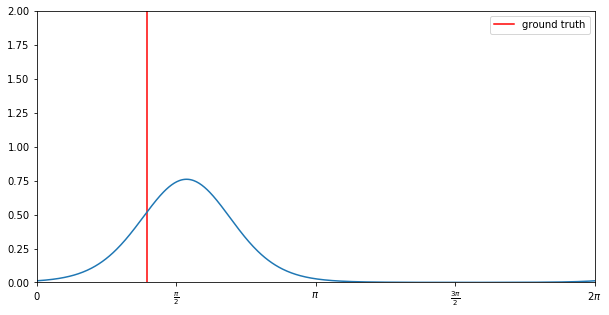

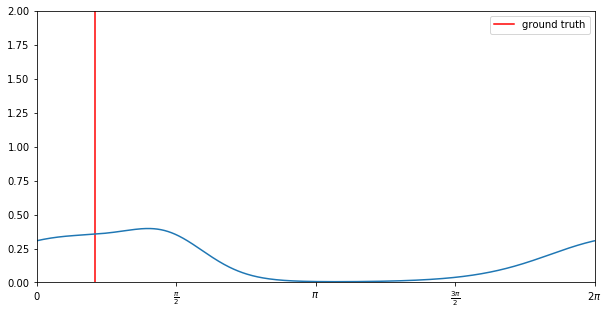

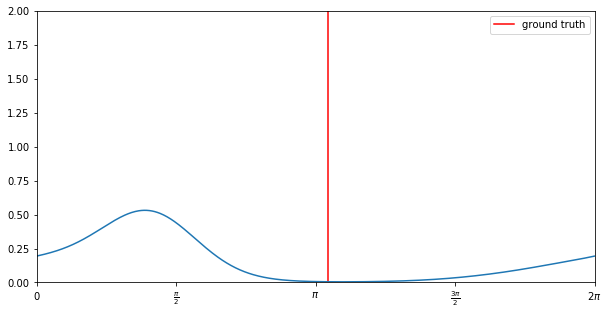

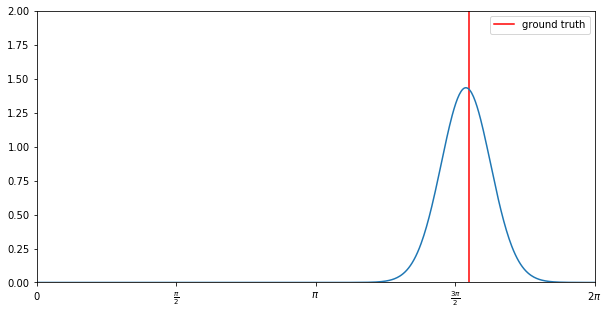

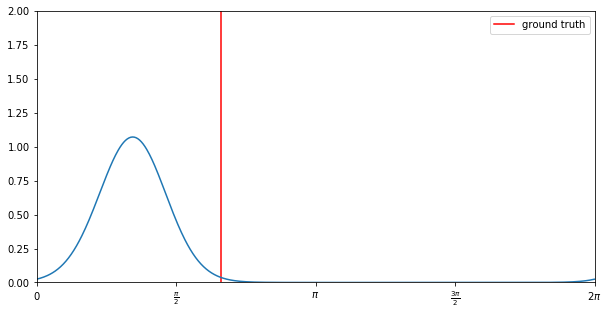

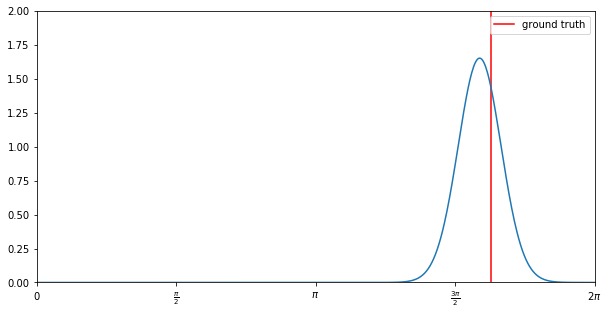

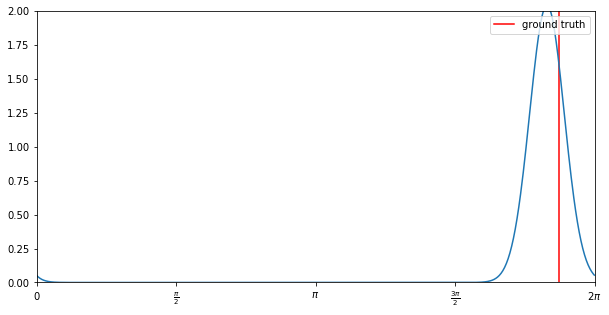

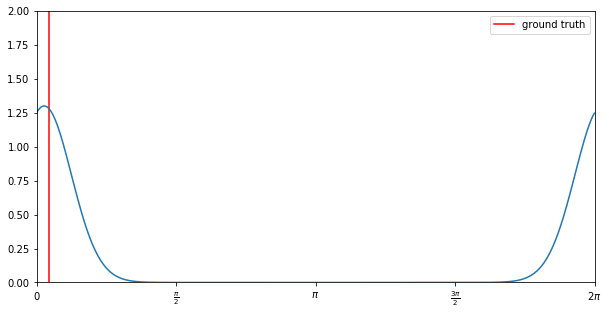

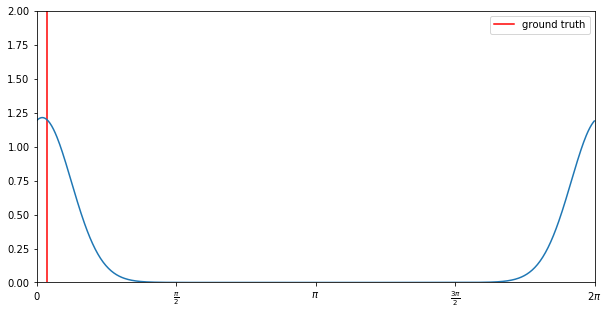

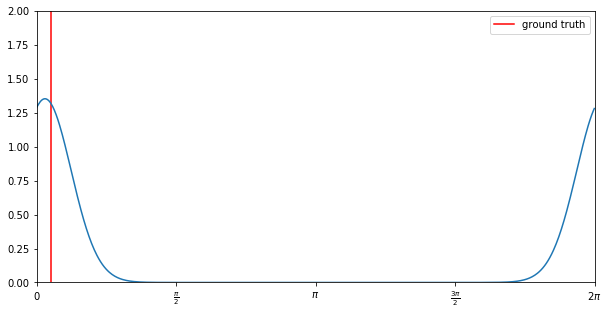

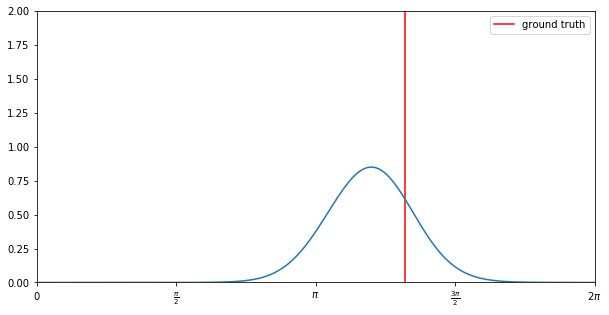

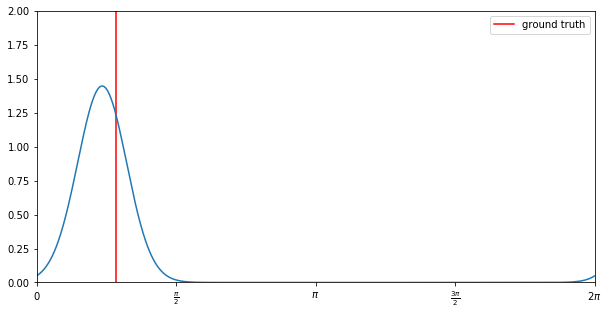

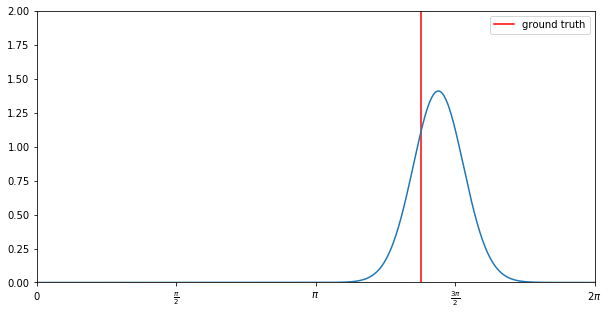

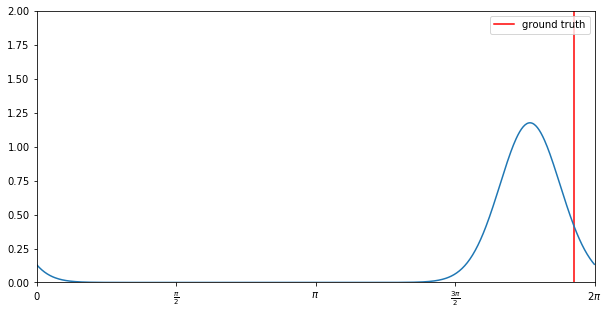

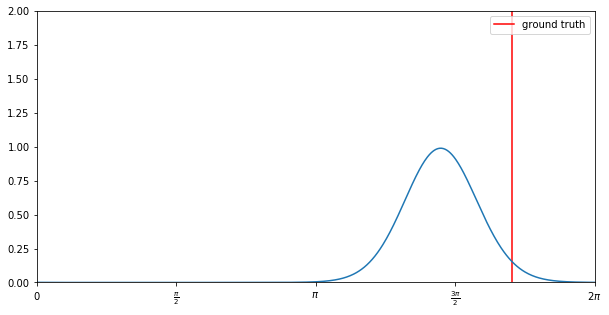

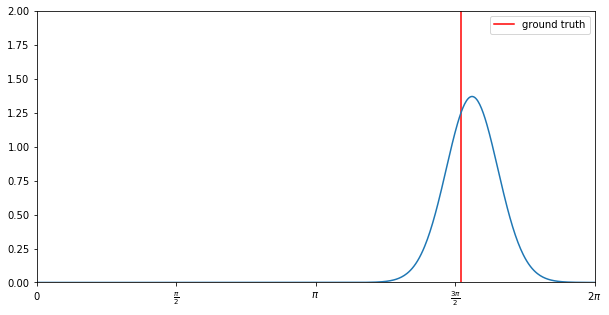

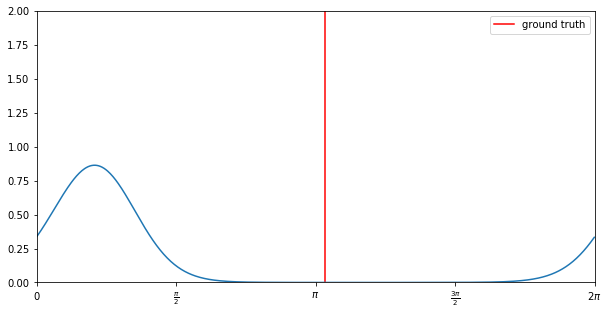

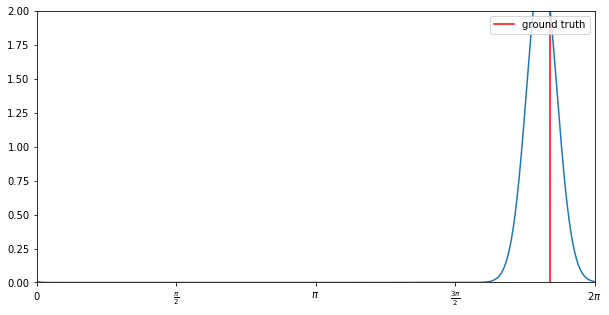

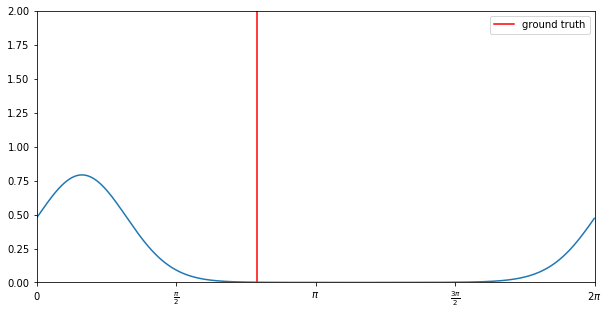

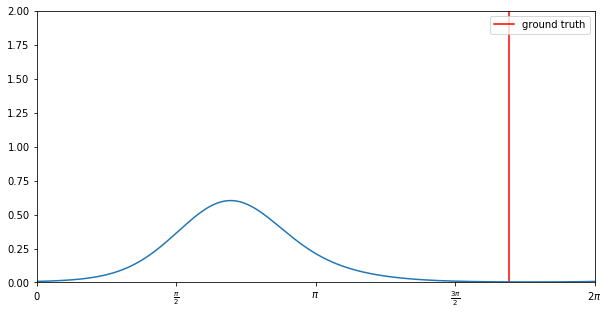

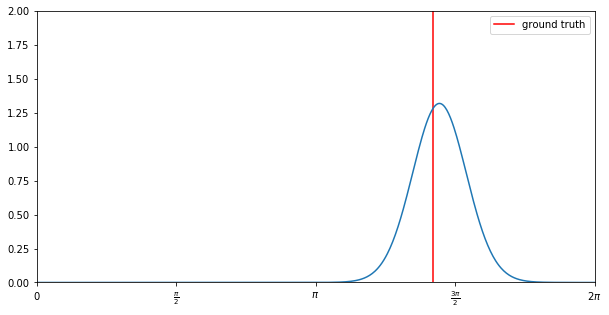

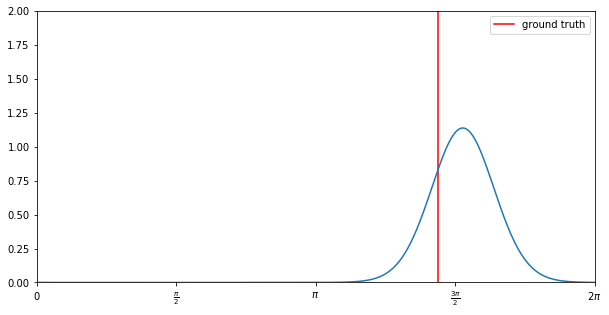

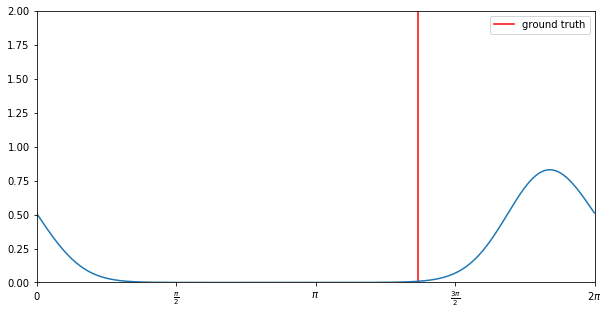

In [32]:
from utils.losses import maximum_expected_utility


data_part = 'test'
images = test_data['images']
y_true = test_data['azimuth_bit']
y_true_deg = test_data['azimuth_deg']
y_true_rad = np.deg2rad(test_data['azimuth_deg'])

print("START!!!")
def _unpack_preds(y_pred):
    
    means = []
    kappas = []
    
    for sid in range(0, n_samples):
        means.append(y_pred[:, sid*3:sid*3+2])
        kappas.append(y_pred[:, sid*3+2:sid*3+3])

    return means, kappas

#y_pred_1 = bidisco.predict(images, batch_size=32, verbose=1)
means_1, kappas_1 = _unpack_preds(y_pred_1)
#y_pred_2 = bidisco.predict(images, batch_size=32, verbose=1)
#means_2, kappas_2 = _unpack_preds(y_pred_2)
#diffs = np.abs(bit2deg(means_1[0])-bit2deg(means_1[1])).astype('int')

#print(diffs)

preds_degs = np.asarray([bit2deg(means_1[i]) for i in range(0, n_samples)]).T
print("MAAD (1 sample) : %f" % np.mean(maad_from_deg(bit2deg(y_true), bit2deg(means_1[0]))))
mae_preds = maximum_expected_utility(preds_degs)
print("MAAD (MAE) : %f" % np.mean(maad_from_deg(bit2deg(y_true), mae_preds)))


#bidisco.load_weights(ckpt_path)
#bidisco.evaluate(test_data['images'], test_data['azimuth_bit'])

likelihoods = np.asarray([np.exp(von_mises_log_likelihood_np(y_true, means_1[i], kappas_1[i])) for i in range(0, n_samples)])
likelihoods = np.squeeze(likelihoods).T
avg_loglikelihood = np.mean(np.log(np.mean(likelihoods, axis=1)))
print("log-likelihood: %f" % avg_loglikelihood)

xvals = np.arange(0, 2*np.pi, 0.01)

means = means_1
kappas = kappas_1

vm_acc_pdf, vm_pdfs = acc_pdf(xvals, means, kappas)

for i in range(0, 50):
    #plot_vm_pdf(x_vals, vm_pdfs[i, 0], y_true=np.deg2rad(bit2deg(means_1[0]))[i])
    plot_vm_pdf(xvals, vm_acc_pdf[i], y_true=y_true_rad[i])

#     theta_mean, theta_kappa = _unpack_preds(y_pred) 
    
#     preds_theta = bit2deg(theta_mean)
#     gt_theta = bit2deg(theta_target)
#     aads = maad_from_deg(gt_theta, preds_theta)
#     theta_maad = np.mean(aads)
#     theta_maad_sem = stats.sem(aads)
#     print("MAAD (%s): %f±%f" %(data_part, theta_maad, theta_maad_sem))
#     if fixed_kappa is not None:
#         theta_kappa = np.ones(theta_kappa.shape)*fixed_kappa
#     theta_lls = von_mises_log_likelihood_np(theta_target, theta_mean, theta_kappa)
#     theta_ll = np.mean(theta_lls)
#     theta_ll_sem = stats.sem(theta_lls)
#     print("Log-likelihood (%s): %f±%f" %(data_part, theta_ll, theta_ll_sem))


In [27]:
likelihoods

array([[0.26262003, 0.24275147, 0.26351325, ..., 0.21357166, 0.20747467,
        0.2841174 ],
       [0.18404273, 0.13824341, 0.13808945, ..., 0.15802861, 0.1670865 ,
        0.16266347],
       [0.12388132, 0.14626119, 0.10985623, ..., 0.13087398, 0.09700779,
        0.14092435],
       ...,
       [0.17404876, 0.17595349, 0.168991  , ..., 0.16256872, 0.15486985,
        0.16794986],
       [0.09218714, 0.07508094, 0.08341239, ..., 0.10684534, 0.08200084,
        0.07579231],
       [0.17242053, 0.14621059, 0.13114948, ..., 0.18339909, 0.1378497 ,
        0.1931592 ]])

(array([  1.,   0.,   0.,   1.,   2.,   2.,   5.,  14.,  32., 218.]),
 array([-25.63076238, -22.9619078 , -20.29305322, -17.62419864,
        -14.95534406, -12.28648948,  -9.61763489,  -6.94878031,
         -4.27992573,  -1.61107115,   1.05778343]),
 <a list of 10 Patch objects>)

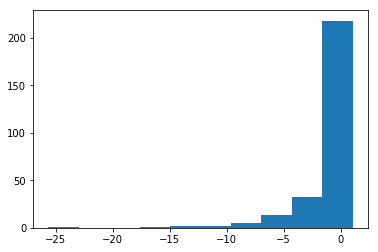

In [21]:
plt.hist(np.log(likelihoods[:,0]))

In [24]:
def acc_pdf(xvals, means, kappas):
    
    n_images = len(means[0])
    
    vm_pdfs = np.zeros([n_images, n_samples, len(xvals)])

    x_vals_tiled = np.ones(n_images)

    for xid, xval in enumerate(xvals):

        for sid in range(0, n_samples):

            x_bit = rad2bit(x_vals_tiled*xval)

            vm_pdfs[:, sid, xid] = np.exp(np.squeeze(von_mises_log_likelihood_np(x_bit,
                                                                      means[sid],
                                                                      kappas[sid])))

    vm_acc_pdf = np.mean(vm_pdfs, axis=1)
    return vm_acc_pdf, vm_pdfs

def plot_vm_pdf(x, pdf, ax=None, y_true=None,):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    xticks = [0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
    xticks_labels = ["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)
    
    if y_true is not None:
        ax.axvline(y_true, c='red', label='ground truth')
    # ax.axvline(np.mean(pdf*x), label='mean')
    ax.plot(x, pdf) 
    ax.set_xlim((0, 2*np.pi))
    ax.set_ylim(0, 2.0)
    ax.legend(loc=1)
    
    return 

In [232]:
np.mean(maad_from_deg(bit2deg(y_true), maximum_expected_utility(preds_degs)))

27.693804265802555

In [180]:
np.mean(np.log(np.mean(likelihoods, axis=1)))

-1.8637657889345762

In [98]:
np.abs(bit2deg(means[0])-bit2deg(means[1])).astype('int')

array([  0,   1,   0,  71,   3,   8,   1,   1,   2,  22,   6,   0,   4,
         0,   2,   0,   1,   0,   1,   2,   0,   0,   0,   0,   2,   2,
         1,  10,  18, 180,   0,   0,   1,   0,   0,   1,   0,   2,   1,
         1,  45,   3,   0,   1,   0,   7,   1,   0,   0,   0,   2,   0,
         0,   1,   5,   0,   0,   0,   0,   4,   1,   1,  25,   3,   0,
         0,  11,   0,  24,   1,   0,   1,   0,  19, 128,   8,   7,   7,
         1,  63,   0,   0,  52,   0,   2,   0,   0,   1,   0,   0,   1,
         0,  44,   0,  22,   1,  33,   0,   0,   2,   0,   0,   0,   1,
        27,   0,   0,   2,   5,   0,   1,   2,   2,   0,   0,   5,   0,
         4,   4,   4,   1,   0,   1,   8,   1,   2,  26,   0,   0,   2,
         0,   1,   3, 317,   4,   0,   1,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   5,   3,   0,   2,   1,   1,   0,   6,   2,   7,
         1,   4,   5,   0,  13,   1,   0,   6,   0,   1,   4,   0,   3,
         1,   0,   0,   0,   0,   2,   0,  11,   0,   0,   2,  1

In [367]:
np.log(np.mean(np.squeeze(likelihoods.T), axis=1))

array([-1.00593878e+00, -7.84102654e+00,  2.20933289e-01,  5.80943107e-01,
        5.87024335e-01, -4.80195742e+01, -6.07876521e+01, -1.00317671e+01,
       -4.45051678e+01,  3.34450850e-01, -2.11759470e+00, -4.41323300e-02,
       -2.25594184e-02,  1.22611679e-01, -1.87765181e+01, -5.92565801e+01,
       -6.30598013e+01, -1.07338731e+00, -3.93493398e-01,  7.87640003e-01,
       -4.40218036e+00,  7.55375706e-01,  7.44779064e-01, -6.86899570e+01,
       -3.06713630e+01, -3.95014406e+01, -5.19766475e+01,  2.25642444e-01,
        7.47066309e-01, -1.47897220e+00,  8.65382002e-01, -1.50984214e+00,
        5.02638396e-01, -2.50382238e-01, -5.92471531e+00,  7.79832474e-02,
        1.26080857e-01, -1.52666290e+01, -8.13862676e-01,  9.09238388e-01,
       -1.76680811e+00, -3.71802791e+01, -8.26502250e+01, -4.83782980e+01,
        1.56296100e+00, -7.19638132e+00, -4.38228790e+01, -1.57894775e+00,
        3.75257096e-01, -4.59951997e+01, -5.61632509e+01, -3.09238448e+00,
       -2.06261520e+01, -

In [365]:
np.mean(np.log(np.mean(likelihoods, axis=1)))

-13.208249990446621

In [351]:
np.log(np.mean(likelihoods, axis=1))

array([-1.00593878e+00, -7.84102654e+00,  2.20933289e-01,  5.80943107e-01,
        5.87024335e-01, -4.80195742e+01, -6.07876521e+01, -1.00317671e+01,
       -4.45051678e+01,  3.34450850e-01, -2.11759470e+00, -4.41323300e-02,
       -2.25594184e-02,  1.22611679e-01, -1.87765181e+01, -5.92565801e+01,
       -6.30598013e+01, -1.07338731e+00, -3.93493398e-01,  7.87640003e-01,
       -4.40218036e+00,  7.55375706e-01,  7.44779064e-01, -6.86899570e+01,
       -3.06713630e+01, -3.95014406e+01, -5.19766475e+01,  2.25642444e-01,
        7.47066309e-01, -1.47897220e+00,  8.65382002e-01, -1.50984214e+00,
        5.02638396e-01, -2.50382238e-01, -5.92471531e+00,  7.79832474e-02,
        1.26080857e-01, -1.52666290e+01, -8.13862676e-01,  9.09238388e-01,
       -1.76680811e+00, -3.71802791e+01, -8.26502250e+01, -4.83782980e+01,
        1.56296100e+00, -7.19638132e+00, -4.38228790e+01, -1.57894775e+00,
        3.75257096e-01, -4.59951997e+01, -5.61632509e+01, -3.09238448e+00,
       -2.06261520e+01, -

array([3.65701160e-01, 3.93265133e-04, 1.24724022e+00, 1.78772365e+00,
       1.79862833e+00, 1.39753896e-21, 3.98343844e-27, 4.39803718e-05,
       4.69516866e-20, 1.39717292e+00, 1.20320688e-01, 9.56827332e-01,
       9.77693142e-01, 1.13044536e+00, 7.00586562e-09, 1.84159551e-26,
       4.10654179e-28, 3.41848606e-01, 6.74695772e-01, 2.19820255e+00,
       1.22506000e-02, 2.12841103e+00, 2.10597610e+00, 1.47343413e-30,
       4.78185363e-14, 6.99426873e-18, 2.67195289e-23, 1.25312752e+00,
       2.11079849e+00, 2.27871774e-01, 2.37591352e+00, 2.20944854e-01,
       1.65307699e+00, 7.78503152e-01, 2.67256844e-03, 1.08110455e+00,
       1.13437389e+00, 2.34308074e-07, 4.43143038e-01, 2.48243116e+00,
       1.70877541e-01, 7.12541163e-17, 1.27486259e-36, 9.76274931e-22,
       4.77293301e+00, 7.49292356e-04, 9.28892562e-20, 2.06191949e-01,
       1.45536553e+00, 1.05812887e-20, 4.06078536e-25, 4.53935853e-02,
       1.10198584e-09, 1.83994575e-01, 1.72502527e+00, 8.27013417e-01,
      

In [328]:
np.log(np.mean(np.squeeze(likelihoods)))

-0.25519782932884216

In [332]:
np.abs(bit2deg(means[1])-bit2deg(means[0])).astype('int')

array([  1,   4,   0,   1,   0,   6,   1,   0,   1,   5,   0,   7,  13,
         1,   3,   1,   0,   0,   0,   1,   0,   0,   1,   1,  19,   2,
         0,   1,   0, 133,   1,   3,   0,   0,   0,   4,   3,   4,   0,
         1,   0,   3,   0,   1,   0,   0,   4,   0,   0,   3,   0,   1,
         7,   4,   1,   1,   0,   0,   0,   3,   0,  13,   3,   0,   0,
         6,   1,   1,   2,   0,   0,   2,   3,   0,   1,   2,   0,   1,
         0,  23,   0,   2,   2,   0,   0,   0,   9,   2,   2,   2,   0,
         0,   1,   1,  15,   0,  29,   1,   1,   0,   0,   6,   1,  11,
         0,   0,   0,   2,   2,   1,   0,   6,   1,   0,   2,   5,   0,
         1,   1,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   2,
         0,   1,   0,   0,   0,   1,   0,   1,   0,   4,   1,   0,   0,
         0,   0,   0,   1,  65,   0,   0,   1,   2,   0,   0,   0,   1,
         1,   0,   2,   1,   0,   2,   1,   1,   0,   0,   0,   0,   1,
         1,   0,   0,   2,   1,   0,   0,   2,   0,   1,   2,   

In [329]:
bit2deg(means[0])

array([ 31.651337 , 219.71153  ,  93.10022  , 350.0396   ,  91.22131  ,
       115.49347  , 125.11905  , 249.27179  ,  37.04831  ,  88.15781  ,
        86.48279  , 112.51233  ,  83.53125  ,  50.297516 ,  13.2421875,
       100.21527  ,  98.17053  , 101.90234  ,  90.72415  ,  92.2663   ,
        88.41797  , 298.09497  ,  88.85507  ,  35.696686 ,  37.2164   ,
        17.177704 ,  46.97223  ,  81.44885  ,  44.339874 , 238.14609  ,
       285.32315  ,  92.60394  , 285.04343  , 326.83365  , 335.7545   ,
       356.9279   , 354.51175  , 147.12524  ,  65.12067  , 251.60202  ,
       331.47745  , 142.66705  ,  97.9971   ,  40.36847  , 329.57098  ,
        92.26181  ,  96.91232  , 271.4677   , 267.7531   , 109.473755 ,
       114.17322  , 273.55103  , 198.3283   ,  93.96994  , 100.65509  ,
       247.09966  ,  92.65488  ,  12.3923645,  10.882629 , 110.10968  ,
        87.47894  , 243.62213  , 102.79605  , 106.29767  , 242.4813   ,
        74.64957  , 343.11127  ,  96.83655  ,  25.637878 ,  49.7

In [284]:
#np.abs(bit2deg(means[0])-bit2deg(means[1])-bit2deg(means[0])+bit2deg(means[2])).astype('int')

array([ 29,   1,   1,  12,   0,   4,   0,   0,  10,   1,   2,   1,   4,
         0,   1,   0,   0,   1,   2,   0,   0,   0,   2,   0,   0,   0,
         1,   2,   0,   1,   0,   0,   0,   2,   0,   1,   1,   2,   0,
         0,   0,   3,   0,   3,   0,  29,   2,   0,   1,   1,   2,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   1,   0,
         0,   0,   1,  14,   0,   3,   6,   2,   3,   0,   0,  17,   1,
         2,   5,   2,   1,   0,   0,   1,   0,   0,   1,   4,   1,   1,
         1,   1,   1,   0,   0,  23,   0,   1,   0,   0,   1,   0,   0,
         9,   0,   0,   0,   3,   2,   0,   0,   1,   1,   2,   0,   1,
         1,  55,   0,   0,   0,   0,   0,   1,   2,   0,   2,   0,   0,
         0,   1,   1,  13,   0,   0,   1,   0,   0,   3,   2,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0,   2,
         2,   3,   5,   1,   0,   5,   0,   2,   0,   0,   0,   0,   7,
         1,   3,   0,   0,   0,   3,   1,   0,   1,   0,   1,  1

In [ ]:
y_pred = model.predict(images, batch_size=32, verbose=1)


In [69]:
bidisco.predict(val_data['images'][0:5])

array([[-9.2030674e-01,  3.9119756e-01,  1.0327242e+04, -9.2030489e-01,
         3.9120188e-01,  1.0326915e+04, -9.2030489e-01,  3.9120170e-01,
         1.0327081e+04, -9.2030531e-01,  3.9120087e-01,  1.0327273e+04,
        -9.2030388e-01,  3.9120412e-01,  1.0327044e+04, -9.2030615e-01,
         3.9119890e-01,  1.0327104e+04, -9.2030454e-01,  3.9120272e-01,
         1.0327082e+04, -9.2030531e-01,  3.9120093e-01,  1.0327262e+04,
        -9.2030519e-01,  3.9120114e-01,  1.0327212e+04, -9.2030525e-01,
         3.9120090e-01,  1.0327348e+04],
       [-9.1996020e-01,  3.9201182e-01,  9.0975166e+03, -9.1995895e-01,
         3.9201468e-01,  9.0976455e+03, -9.1995609e-01,  3.9202148e-01,
         9.0978105e+03, -9.1995996e-01,  3.9201230e-01,  9.0977891e+03,
        -9.1996044e-01,  3.9201117e-01,  9.0977705e+03, -9.1996080e-01,
         3.9201045e-01,  9.0976416e+03, -9.1996139e-01,  3.9200902e-01,
         9.0978066e+03, -9.1995925e-01,  3.9201415e-01,  9.0977764e+03,
        -9.1996151e-01,

In [25]:
ckpt_path = '../logs/azimuth_vae.ckpt' 
angle = 'azimuth'
angle_key = angle+'_bit'

early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

cvae_model.fit(train_data=[train_data['images'], train_data['azimuth_bit']],
               val_data=[val_data['images'], val_data['azimuth_bit']],
               n_epochs=200,
               batch_size=32,
               callbacks=[early_stop_cb, model_ckpt])

Train on 2247 samples, validate on 562 samples
Epoch 1/200
2247/2247 [==============================] - 38s 17ms/step - loss: 310.0694 - val_loss: 43.4323

Epoch 00001: val_loss improved from inf to 43.43234, saving model to ../logs/azimuth_vae.ckpt
Epoch 2/200
2247/2247 [==============================] - 36s 16ms/step - loss: 41.0276 - val_loss: 9.7663

Epoch 00002: val_loss improved from 43.43234 to 9.76634, saving model to ../logs/azimuth_vae.ckpt
Epoch 3/200
2247/2247 [==============================] - 36s 16ms/step - loss: 11.5876 - val_loss: 8.3897

Epoch 00003: val_loss improved from 9.76634 to 8.38974, saving model to ../logs/azimuth_vae.ckpt
Epoch 4/200
2247/2247 [==============================] - 36s 16ms/step - loss: 8.6758 - val_loss: 7.1049

Epoch 00004: val_loss improved from 8.38974 to 7.10486, saving model to ../logs/azimuth_vae.ckpt
Epoch 5/200
2247/2247 [==============================] - 36s 16ms/step - loss: 6.9883 - val_loss: 6.1617

Epoch 00005: val_loss improved f

In [26]:
cvae_model.evaluate(val_data['images'][0:64], np.squeeze(val_data['azimuth_deg'][0:64]), 'validation', batch_size=32)

MAAD error (validation) : 72.189667 pm 6.049932SEM
ELBO (validation) : -2.347614 pm 0.105198SEM
Approx Log-Likelihood, importance sampling (validation) : -1.788101 pm 0.068817SEM
KL-div (validation) : 0.506976 pm0.027339SEM


{'elbo': -2.347613873844557,
 'elbo_sem': array([0.10519829]),
 'importance_log_likelihood': -1.7881012113346126,
 'importance_log_likelihood_sem': 0.06881673072806291,
 'kl_div': 0.5069757762830704,
 'kl_div_sem': array([0.02733904]),
 'maad_loss': 72.18966680323987,
 'maad_loss_sem': 6.04993187620864}

In [185]:
vae_preds = bivae.predict(train_data['images'][0:10])
vae_preds1 = bivae.predict(train_data['images'][0:10])
vae_preds2 = bivae.predict(train_data['images'][0:10])

In [186]:
bit2deg(vae_preds1[:, 0:2])

array([278.2521  , 341.25226 ,  42.73645 , 212.92383 ,  55.25049 ,
       249.07787 , 288.41733 ,  51.944885, 291.53912 ,   7.59729 ],
      dtype=float32)

In [188]:
bit2deg(vae_preds2[:, 0:2])

array([278.1497  , 340.9263  ,  42.20575 , 218.58795 ,  55.26419 ,
       249.66507 , 288.4512  ,  53.173523, 291.80756 ,   7.910492],
      dtype=float32)

In [190]:
bit2deg(vae_preds[:, 0:2])

array([278.11356  , 340.80054  ,  41.766968 , 218.4258   ,  54.90985  ,
       248.23105  , 288.72705  ,  52.86035  , 291.55945  ,   7.8191833],
      dtype=float32)